In [7]:
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
# USEFUL FUNCTION FOR DATA ANALYSIS #
def find_repo_root() -> Path:
    return next(p for p in Path.cwd().parents if (p / "pyproject.toml").exists())


def read_stats_df(stats_path: Path) -> pd.DataFrame:
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)


def read_state_df(state_path: Path) -> pd.DataFrame:
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df


def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())


def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())


### Example on how to load the result of the simulation in a pandas DataFrame

In [8]:
# Get path where the results are
repo_root = find_repo_root()
folder_name = repo_root / "results" / "trial"  

# Read output of the simulations
stats_df = read_stats_df(folder_name / "stats.h5")
state_df = read_state_df(folder_name / "state.h5")
# parameters = read_config(folder_name / "config_used.json")
# timings = read_timings(folder_name / "timings.json")

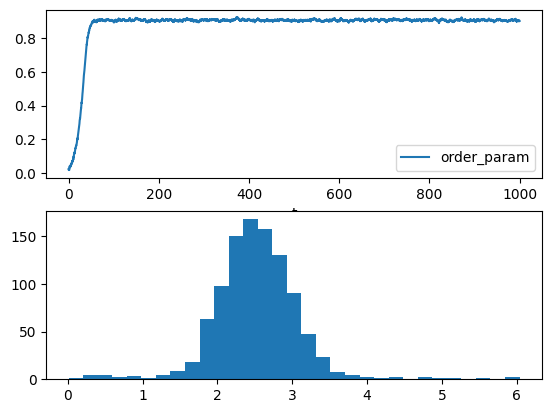

In [9]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
stats_df.plot(x="t", y="order_param",ax=ax[0])
ax[1].hist(state_df["x_0"], bins=int(np.sqrt(state_df.shape[1])));

## Phase diagram

Aggregate the sweep results and plot order parameter vs. theta.


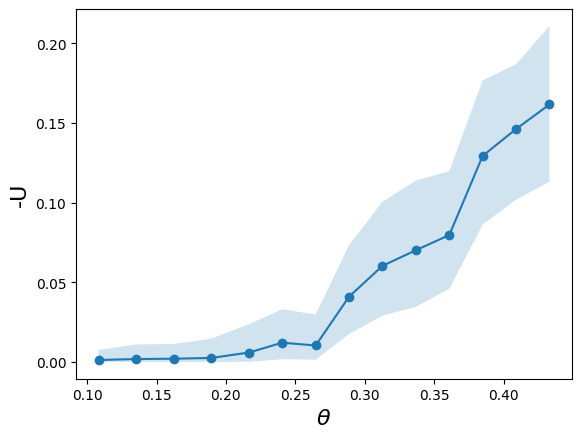

In [14]:
from matplotlib import pyplot as plt


# Summarize the steady-state order parameter and record the time window used.
def summarize_order_param(stats_path: Path, frac: float = 0.8) -> dict:
    df = read_stats_df(stats_path)
    if "order_param" not in df.columns:
        raise ValueError("order_param column missing from stats.")
    if "t" not in df.columns:
        raise ValueError("t column missing from stats.")
    t_max = float(df["t"].max())
    t_start = frac * t_max
    tail = df[df["t"] >= t_start]
    if tail.empty:
        raise ValueError("No samples in tail window; check frac/t_max.")
    return {
        "order_param": float(tail["order_param"].mean()),
        "r_min": float(tail["order_param"].min()),
        "r_max": float(tail["order_param"].max()),
        "t_start": float(tail["t"].iloc[0]),
        "t_end": float(tail["t"].iloc[-1]),
    }


# Build a per-run table by reading each run folder's config_used.json.
def build_phase_diagram(sweep_dir: Path, frac: float = 0.8) -> pd.DataFrame:
    sweep_dir = Path(sweep_dir)
    rows = []
    for run_dir in sorted(sweep_dir.iterdir()):
        if not run_dir.is_dir():
            continue
        config_path = run_dir / "config_used.json"
        stats_path = run_dir / "stats.h5"
        if not (config_path.exists() and stats_path.exists()):
            continue
        config_used = read_config(config_path)
        theta = config_used["system"]["params"]["theta"]
        summary = summarize_order_param(stats_path, frac=frac)
        rows.append({
            "run": run_dir.name,
            "theta": theta,
            **summary,
        })
    return pd.DataFrame(rows)


# Aggregate across reps for each theta and plot energy with min/max bands.
sweep_dir = repo_root / "results/sweep_theta_Kuramoto_Bistable_Graphon_local"


phase_df = build_phase_diagram(sweep_dir, frac=0.8)
phase_summary = phase_df.groupby("theta", as_index=False).agg(
    mean=("order_param", "mean"),
    r_min=("r_min", "mean"),
    r_max=("r_max", "mean"),
    t_start=("t_start", "mean"),
    t_end=("t_end", "mean"),
)
phase_summary["energy_mean"] = 0.5 * phase_summary["mean"] ** 2
phase_summary["energy_min"] = 0.5 * phase_summary["r_max"] ** 2
phase_summary["energy_max"] = 0.5 * phase_summary["r_min"] ** 2

ax = phase_summary.plot(x="theta", y="energy_mean", marker="o",legend=False)
ax.fill_between(
    phase_summary["theta"],
    phase_summary["energy_min"],
    phase_summary["energy_max"],
    alpha=0.2,
)
ax.set_ylabel("-U",size=16)
ax.set_xlabel(r"$\theta$",size=16)
plt.show()


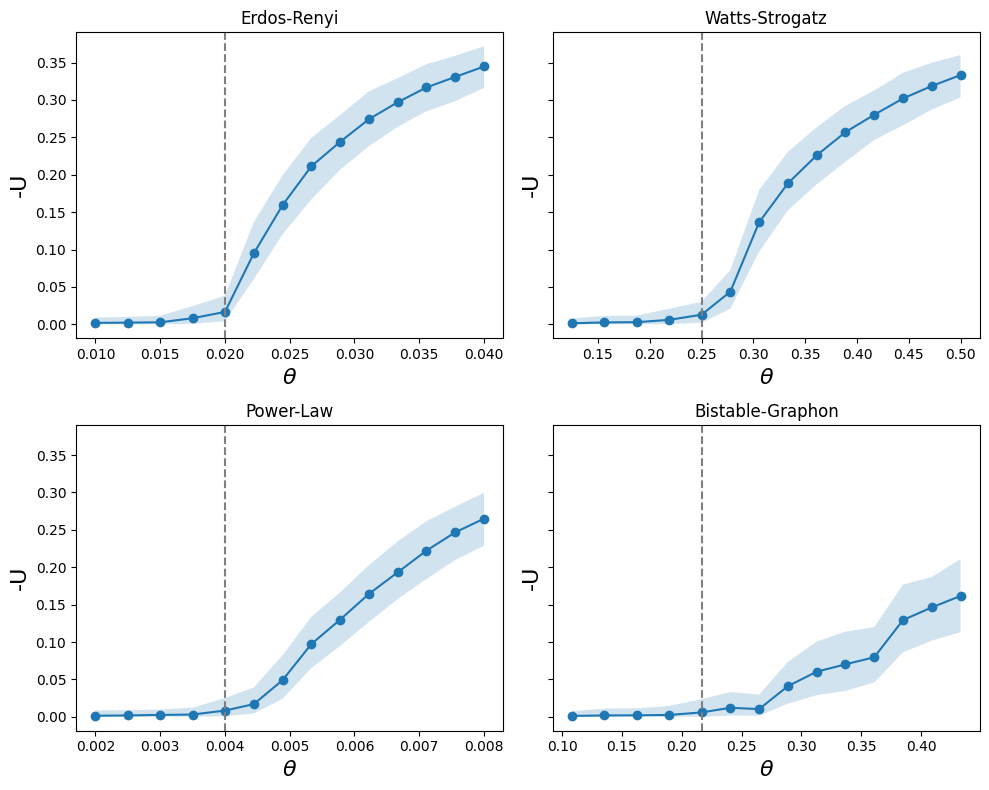

In [15]:
# Phase diagrams across network families
from matplotlib import pyplot as plt

def first_run_config(sweep_dir: Path) -> dict:
    for run_dir in sorted(Path(sweep_dir).iterdir()):
        if not run_dir.is_dir():
            continue
        cfg_path = run_dir / "config_used.json"
        if cfg_path.exists():
            return read_config(cfg_path)
    raise ValueError(f"No config_used.json found in {sweep_dir}")

def summarize_phase(sweep_dir: Path, frac: float = 0.8) -> pd.DataFrame:
    phase_df = build_phase_diagram(sweep_dir, frac=frac)
    if phase_df.empty:
        raise ValueError(f"No runs found in {sweep_dir}")
    phase_summary = phase_df.groupby("theta", as_index=False).agg(
        mean=("order_param", "mean"),
        r_min=("r_min", "mean"),
        r_max=("r_max", "mean"),
    )
    phase_summary["energy_mean"] = 0.5 * phase_summary["mean"] ** 2
    phase_summary["energy_min"] = 0.5 * phase_summary["r_max"] ** 2
    phase_summary["energy_max"] = 0.5 * phase_summary["r_min"] ** 2
    return phase_summary

sweep_dirs = {
    "Erdos-Renyi": repo_root / "results" / "sweep_theta_Kuramoto_ER_local",
    "Watts-Strogatz": repo_root / "results" / "sweep_theta_Kuramoto_Watts_Strogatz_local",
    "Power-Law": repo_root / "results" / "sweep_theta_Kuramoto_Power_Law_local",
    "Bistable-Graphon": repo_root / "results" / "sweep_theta_Kuramoto_Bistable_Graphon_local",
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.ravel()

for ax, (title, sweep_dir) in zip(axes, sweep_dirs.items()):
    cfg = first_run_config(sweep_dir)
    sigma = cfg["noise"]["params"]["sigma"]
    phase_summary = summarize_phase(sweep_dir, frac=0.8)

    if title == "Erdos-Renyi":
        p = cfg["network"]["params"]["p"]
        theta_c = sigma ** 2 / p
    elif title == "Watts-Strogatz":
        k = cfg["network"]["params"]["k"]
        n = cfg["network"]["params"]["n"]
        h = k / n
        theta_c = sigma ** 2 / h
    elif title == "Power-Law":
        alpha = cfg["network"]["params"]["alpha"]
        theta_c = sigma ** 2 * (1 - 2 * alpha)
    else:
        theta_c = sigma ** 2 / 0.04618426230106129

    ax.plot(phase_summary["theta"], phase_summary["energy_mean"], marker="o")
    ax.fill_between(
        phase_summary["theta"],
        phase_summary["energy_min"],
        phase_summary["energy_max"],
        alpha=0.2,
    )
    ax.axvline(theta_c, linestyle="--", color="gray")
    ax.set_title(title)
    ax.set_xlabel(r"$\theta$", size = 16)
    ax.set_ylabel("-U", size = 16)

plt.tight_layout()
plt.show()
